In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

# The deep learning model was trained using Keras functional API, 
# running on top of TensorFlow in Google Colaboratory online platform 
# with Python 3.6 notebook.
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model, Model, Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D

**About the original paper:**
*   Title: Application of deep and machine learning techniques for multi-label classification performance on psychotic disorder diseases
*   Authors: Israel Elujide, Stephen G. Fashoto, Bunmi Fashoto, Elliot Mbunge, Sakinat O. Folorunso, Jeremiah O. Olamijuwon
*   Dataset: The data were obtained from Yaba Psychiatry Hospital, Yaba, Lagos State, Nigeria by Adejumo et al.
*   Link: https://www.sciencedirect.com/science/article/pii/S2352914821000356

# Dependencies

**Basic**

Process the file:
*   from google.colab import files

Process the data:
*   import numpy as np
*   import pandas as pd

Split data into train and test subsets:
*   from sklearn.model_selection import train_test_split


**Balancing data**

*   from imblearn.over_sampling import SMOTE


**Machine learning**

*   from sklearn.neural_network import MLPClassifier
*   from sklearn.svm import LinearSVC
*   from sklearn.ensemble import RandomForestClassifier
*   from sklearn.tree import DecisionTreeClassifier

**Deep learning**

Keras funtional API:
*   from tensorflow import keras
*   from keras.models import load_model, Model, Sequential # Sequential groups a linear stack of layers into a tf.keras.Model.
*   from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D



# Import Files

**How to access to the dataset:**

Please go the Appendix A of the [paper](https://www.sciencedirect.com/science/article/pii/S2352914821000356#cebib0010) or download through this [link](https://www.sciencedirect.com/science/article/pii/S2352340917303487#ec0010):


*   In the section 'Extras', please click on 'Download all' to get the cvs file.
*   Click on 'Choose Files' to upload the csv file here.



In [2]:
# Upload data file if using google colab
# from google.colab import files
# uploaded = files.upload()

# df = pd.read_csv(io.BytesIO(uploaded['data.csv']),encoding='cp1252')

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')
path = "/content/drive/MyDrive/data.csv"

df = pd.read_csv(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
df

,sex,age,faNoily_status,religion,occupation,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,Insominia,shizopherania,vascula_demetia,MBD,Bipolar,agecode
0,M,18,Yes,C,STUDENT,Yes,S,Yes,No,No,Yes,N,P,P,P,N,1
1,F,30,Yes,M,ARTISAN,Yes,S,Yes,No,Yes,Yes,P,P,P,N,N,1
2,M,22,Yes,C,STUDENT,No,S,No,No,No,Yes,P,P,P,N,P,1
3,M,35,No,M,ARTISAN,No,M,No,No,No,Yes,P,P,N,N,P,2
4,M,30,Yes,M,ARTISAN,Yes,M,No,No,No,Yes,P,P,P,P,P,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,F,73,Yes,M,RETIRED,Yes,S,Yes,No,No,Yes,P,N,P,N,P,3
496,F,50,No,M,ARTISAN,No,M,Yes,No,No,No,P,P,N,P,P,2
497,F,32,No,C,FORCE,No,M,No,No,No,Yes,N,P,P,P,N,2
498,M,13,Yes,C,STUDENT,No,S,Yes,No,No,No,N,P,N,N,N,1


In [4]:
set(df['Bipolar'])

{'N', 'P'}

# Data Preprocessing

**Encode data**


*   The Negative or N values are encoded as 0 and the Positive or P values are encoded as 1.
*   Add 'target' column with all combinations with more than 6 occurrences.



In [5]:
## Binary and One-hot encoding for categorial variables

# Encode 'sex' (F/M) into binary value
df['sex'].replace(['F', 'M'], [0, 1], inplace=True)

# Encode 'faNoily_status' (No/Yes) into binary value
df['faNoily_status'].replace(['No', 'Yes'], [0, 1], inplace=True)

# Encode 'genetic' (No/Yes) into binary value
df['genetic'].replace(['No', 'Yes'], [0, 1], inplace=True)

# Encode 'status' (M/S) into binary value
df['status'].replace(['M', 'S'], [0, 1], inplace=True)

# Encode 'loss_of_parent' (No/Yes) into binary value
df['loss_of_parent'].replace(['No', 'Yes'], [0, 1], inplace=True)

# Encode 'divorse' (No/Yes) into binary value
df['divorse'].replace(['No', 'Yes'], [0, 1], inplace=True)

# Encode 'Injury' (No/Yes) into binary value
df['Injury'].replace(['No', 'Yes'], [0, 1], inplace=True)

# Encode 'Spiritual_consult' (No/Yes) into binary value
df['Spiritual_consult'].replace(['No', 'Yes'], [0, 1], inplace=True)



# region
dum_religion = pd.get_dummies(df.religion, prefix='religion')
df = pd.concat([df, dum_religion], axis=1)
df.drop('religion', inplace=True, axis=1)

# occupation
dum_occ = pd.get_dummies(df.occupation, prefix='occupation')
df = pd.concat([df, dum_occ], axis=1)
df.drop('occupation', inplace=True, axis=1)

# agecode
dum_agecode = pd.get_dummies(df.agecode, prefix='agecode')
df = pd.concat([df, dum_agecode], axis=1)
df.drop('agecode', inplace=True, axis=1)



# Insominia (N/P)
df['Insominia'].replace(['N', 'P'], [0, 1], inplace=True)

# MBD (N/P)
df['MBD'].replace(['N', 'P'], [0, 1], inplace=True)

# Bipolar (N/P)
df['Bipolar'].replace(['N', 'P'], [0, 1], inplace=True)

# shizopherania (N/P)
df['shizopherania'].replace(['N', 'P'], [0, 1], inplace=True)

# vascula_demetia (N/P)
df['vascula_demetia'].replace(['N', 'P'], [0, 1], inplace=True)

data_original = df.copy()

data_original

,sex,age,faNoily_status,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,Insominia,...,religion_O,occupation_ARTISAN,occupation_C/SERVANT,occupation_FORCE,occupation_RETIRED,occupation_STUDENT,occupation_UNEMPLYD,agecode_1,agecode_2,agecode_3
0,1,18,1,1,1,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,30,1,1,1,1,0,1,1,1,...,0,1,0,0,0,0,0,1,0,0
2,1,22,1,0,1,0,0,0,1,1,...,0,0,0,0,0,1,0,1,0,0
3,1,35,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,1,0
4,1,30,1,1,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,73,1,1,1,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
496,0,50,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
497,0,32,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
498,1,13,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


Our target variables are in this order: Insomnia, schizophrenia, vascular dementia, ADHD and Bi-polar disorder.

In [6]:
data = df.copy()
data['target'] = data['Insominia'].astype(str) + data['shizopherania'].astype(str) + data['vascula_demetia'].astype(str) + data['MBD'].astype(str) + data['Bipolar'].astype(str)

data

,sex,age,faNoily_status,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,Insominia,...,occupation_ARTISAN,occupation_C/SERVANT,occupation_FORCE,occupation_RETIRED,occupation_STUDENT,occupation_UNEMPLYD,agecode_1,agecode_2,agecode_3,target
0,1,18,1,1,1,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,01110
1,0,30,1,1,1,1,0,1,1,1,...,1,0,0,0,0,0,1,0,0,11100
2,1,22,1,0,1,0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,11101
3,1,35,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,1,0,11001
4,1,30,1,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,0,11111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,73,1,1,1,1,0,0,1,1,...,0,0,0,1,0,0,0,0,1,10101
496,0,50,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,1,0,11011
497,0,32,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,01110
498,1,13,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,01000


In [7]:
# Paper page 9 - "As such, we removed all combinations with less than 6 occurrences."
data = data.groupby('target').filter(lambda x: len(x) > 6)

imbalanced_data = data.copy()
# we have 'target' for these values
del imbalanced_data['Insominia']
del imbalanced_data['shizopherania']
del imbalanced_data['vascula_demetia']
del imbalanced_data['MBD']
del imbalanced_data['Bipolar']

balanced_data = data.copy()

del data['target']

In [8]:
imbalanced_data

,sex,age,faNoily_status,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,religion_C,...,occupation_ARTISAN,occupation_C/SERVANT,occupation_FORCE,occupation_RETIRED,occupation_STUDENT,occupation_UNEMPLYD,agecode_1,agecode_2,agecode_3,target
0,1,18,1,1,1,1,0,0,1,1,...,0,0,0,0,1,0,1,0,0,01110
2,1,22,1,0,1,0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,11101
3,1,35,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,11001
4,1,30,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,11111
5,0,86,1,0,0,1,0,0,1,1,...,0,0,0,1,0,0,0,0,1,01100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,73,1,1,1,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,10101
496,0,50,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,11011
497,0,32,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,01110
498,1,13,1,0,1,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,01000


In [9]:
balanced_data

,sex,age,faNoily_status,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,Insominia,...,occupation_ARTISAN,occupation_C/SERVANT,occupation_FORCE,occupation_RETIRED,occupation_STUDENT,occupation_UNEMPLYD,agecode_1,agecode_2,agecode_3,target
0,1,18,1,1,1,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,01110
2,1,22,1,0,1,0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,11101
3,1,35,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,1,0,11001
4,1,30,1,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,0,11111
5,0,86,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,01100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,73,1,1,1,1,0,0,1,1,...,0,0,0,1,0,0,0,0,1,10101
496,0,50,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,1,0,11011
497,0,32,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,01110
498,1,13,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,01000


# Balance dataset with SMOTE
Just try SMOTE


In [10]:
temp = data.copy()
y = temp.pop('Insominia')
X = temp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train  

,sex,age,faNoily_status,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,shizopherania,...,religion_O,occupation_ARTISAN,occupation_C/SERVANT,occupation_FORCE,occupation_RETIRED,occupation_STUDENT,occupation_UNEMPLYD,agecode_1,agecode_2,agecode_3
323,0,44,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
81,1,41,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
186,0,40,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
402,0,34,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
241,0,24,1,1,1,1,0,0,1,1,...,1,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,1,43,0,0,0,1,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
309,0,24,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
7,1,46,0,1,0,1,0,0,1,1,...,0,0,1,0,0,0,0,0,1,0
153,1,43,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [13]:
# every sample had a total of 101 samples each
smote = SMOTE(random_state=101)
X_train_balance, y_train_balance = smote.fit_resample(X_train, y_train.ravel())
X_train_balance

,sex,age,faNoily_status,genetic,status,loss_of_parent,divorse,Injury,Spiritual_consult,shizopherania,...,religion_O,occupation_ARTISAN,occupation_C/SERVANT,occupation_FORCE,occupation_RETIRED,occupation_STUDENT,occupation_UNEMPLYD,agecode_1,agecode_2,agecode_3
0,0,44,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
1,1,41,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
2,0,40,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
3,0,34,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,0,24,1,1,1,1,0,0,1,1,...,1,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,0,60,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
398,0,43,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
399,0,50,0,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
400,0,67,1,1,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


# Multi-Label Classification Model on dataset with class imbalance.

# Machine learning

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Train a Multilayer Perceptron (MLP), Support Vector Machines (SVM), Random Forest (RF) and Decision Tree (DT) on the training data (which is 80% of the whole data). The four algorithms are evaluated on the test set (which is 20% of the sampled data). The accuracy and balanced accuracy are as presented in Table 3.

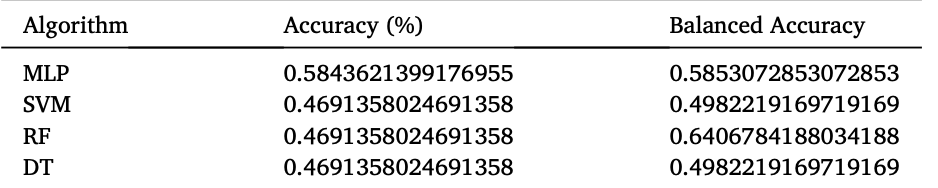


In [21]:
ml_results = []
dl_results = []

In [22]:
temp = imbalanced_data.copy()
y_multi_imbalanced = temp.pop('target')
X_multi_imbalanced = temp
X_train, X_test, y_train, y_test = train_test_split(X_multi_imbalanced, y_multi_imbalanced, test_size=0.2)

Multilayer Perceptron (MLP)

In [23]:
MLP = MLPClassifier()
MLP.fit(X_train, y_train)
mlp_score = MLP.score(X_test, y_test)
ml_results.append(f"Imbalanced data - MLP: {mlp_score}")
print(f"MLP for imbalanced data = {mlp_score}")

MLP for imbalanced data = 0.4536082474226804


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Support Vector Machines (SVM)

In [24]:
svc = LinearSVC()
svc.fit(X_train, y_train)
svm_score = svc.score(X_test, y_test)
ml_results.append(f"Imbalanced data - SVM: {svm_score}")
print(f"SVM for imbalanced data = {svm_score}")

SVM for imbalanced data = 0.36082474226804123


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Random Forest (RF)

In [25]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
rf_score = RF.score(X_test, y_test)
ml_results.append(f"Imbalanced data - RF: {rf_score}")
print(f"RF for imbalanced data = {rf_score}")

RF for imbalanced data = 0.41237113402061853


Decision Tree (DT)

In [26]:
decistion_tree = DecisionTreeClassifier()
decistion_tree.fit(X_train, y_train)
dt_score = decistion_tree.score(X_test, y_test)
ml_results.append(f"Imbalanced data - DT: {dt_score}")
print(f"DT for imbalanced data = {dt_score}")

DT for imbalanced data = 0.31958762886597936


Deep learning using Neural Network


Use Neural Network in this paper:
https://keras.io/guides/sequential_model/

The architectural setup presented in Fig. 4a and b are 3-layer deep fully-connected network with the RELU activation function and architectural layer are 15–20–20-40–1 and 15-20–20-40–5 respectively. The training data is split into a 30% validation set running for 40 epochs with an early stop monitor on validation loss. The optimizer is Adam with a learning rate of 0.01.


*   Drop-out is chosen over L1 and L2 regularisation in this study
*   Sigmoid and ReLU is the activation function used in this study.
*   Optimizer is Adam with a learning rate of 0.01.
*   The loss function for training is a binary cross-entropy and evaluation metrics accuracy.



In [27]:
def MultiLabelNN():
  # Create 3 layers
  # page 5 - Fig 4.
  # found shape=(10, 22)
  input = Dense(15, input_dim=22, activation="relu", name="Input")
  hidden_layer1 = Dense(20, activation="relu", name="layer1")
  hidden_layer2 = Dense(20, activation="relu", name="layer2") 
  hidden_layer3 = Dense(40, activation="relu", name="layer3") 
  output = Dense(5, activation="sigmoid", name="Output") 

  model = Sequential()

  model.add(input)
  model.add(Dropout(0.1))
  model.add(hidden_layer1)
  model.add(Dropout(0.1))
  model.add(hidden_layer2)
  model.add(Dropout(0.1))
  model.add(hidden_layer3)
  model.add(Dropout(0.1))
  model.add(output)

  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [28]:
temp = balanced_data.copy()
y_multi_nn = pd.DataFrame([temp.pop(x) for x in ['Insominia', 'shizopherania', 'vascula_demetia', 'MBD', 'Bipolar']]).T

X_multi_nn = temp

# test
X_train, X_test, y_train, y_test = train_test_split(X_multi_nn, y_multi_nn, test_size=0.2)

# validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

model = MultiLabelNN()
model.fit(
    tf.convert_to_tensor(np.asarray(X_train).astype('int')), 
    tf.convert_to_tensor(y_train),
    epochs=40, 
    batch_size=10
)

# test
test = model.evaluate(tf.convert_to_tensor(np.asarray(X_test).astype('int')), tf.convert_to_tensor(y_test), batch_size=10)

# validation
validation = model.evaluate(tf.convert_to_tensor(np.asarray(X_validation).astype('int')), tf.convert_to_tensor(y_validation), batch_size=10)

print(f'Training Loss and Accuracy (test): {test}')
print(f'Training Loss and Accuracy (validation): {validation}')
dl_results.append(f"Imbalanced data - Multi-label NN Loss and Accuracy(test): {test[1]}")
dl_results.append(f"Imbalanced data - Multi-label NN Loss and Accuracy(validation): {validation[1]}")

Epoch 1/40
27/27 [==============================] - 2s 4ms/step - loss: 23.8436 - accuracy: 0.3074
Epoch 2/40
27/27 [==============================] - 0s 4ms/step - loss: 1.8502 - accuracy: 0.3037
Epoch 3/40
27/27 [==============================] - 0s 5ms/step - loss: 1.1362 - accuracy: 0.5111
Epoch 4/40
27/27 [==============================] - 0s 4ms/step - loss: 0.6746 - accuracy: 0.5593
Epoch 5/40
27/27 [==============================] - 0s 3ms/step - loss: 0.7532 - accuracy: 0.5667
Epoch 6/40
27/27 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.5407
Epoch 7/40
27/27 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.5630
Epoch 8/40
27/27 [==============================] - 0s 5ms/step - loss: 0.6381 - accuracy: 0.5630
Epoch 9/40
27/27 [==============================] - 0s 4ms/step - loss: 0.7781 - accuracy: 0.5593
Epoch 10/40
27/27 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.5556
Epoch 11/40
27/27 

# Single-Label Classification Model on dataset with class imbalance
Using Neural Network with 3-layer

In [29]:
def SingleLabelNN():
  # Create 3 layers
  # page 5 - Fig 4.
  # found shape=(10, 25)
  input = Dense(15, input_dim=25, activation="relu", name="Input")
  hidden_layer1 = Dense(20, activation="relu", name="layer1")
  hidden_layer2 = Dense(40, activation="relu", name="layer2") 
  hidden_layer3 = Dense(50, activation="relu", name="layer3") 
  output = Dense(1, activation="sigmoid", name="Output") 

  model = Sequential()

  model.add(input)
  model.add(Dropout(0.3))
  model.add(hidden_layer1)
  model.add(Dropout(0.3))
  model.add(hidden_layer2)
  model.add(Dropout(0.3))
  model.add(hidden_layer3)
  model.add(Dropout(0.3))
  model.add(output)

  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [30]:
diseases = ['Insominia', 'shizopherania', 'vascula_demetia', 'MBD', 'Bipolar']

losses = []

for d in diseases:
  X = data_original.copy()
  y = X.pop(d)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

  model = SingleLabelNN()
  model.fit(
      tf.convert_to_tensor(np.asarray(X_train).astype('int')), 
      tf.convert_to_tensor(y_train),
      epochs=40, 
      batch_size=10
  )

  # test
  test = model.evaluate(tf.convert_to_tensor(np.asarray(X_test).astype('int')), tf.convert_to_tensor(y_test), batch_size=10)

  # validation
  validation = model.evaluate(tf.convert_to_tensor(np.asarray(X_validation).astype('int')), tf.convert_to_tensor(y_validation), batch_size=10)

  losses.append(f'{d} - Training Loss and Accuracy (test): {test}')
  losses.append(f'{d} - Training Loss and Accuracy (validation): {validation}')
  dl_results.append(f"Imbalanced data - Single-label {d} NN Loss and Accuracy(test): {test[1]}")
  dl_results.append(f"Imbalanced data - Single-label {d} NN Loss and Accuracy(validation): {validation[1]}")

for l in losses:
  print(l)

Epoch 1/40
28/28 [==============================] - 1s 4ms/step - loss: 0.8115 - accuracy: 0.5036
Epoch 2/40
28/28 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.6393
Epoch 3/40
28/28 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.6786
Epoch 4/40
28/28 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6607
Epoch 5/40
28/28 [==============================] - 0s 3ms/step - loss: 0.5956 - accuracy: 0.6929
Epoch 6/40
28/28 [==============================] - 0s 4ms/step - loss: 0.5310 - accuracy: 0.7500
Epoch 7/40
28/28 [==============================] - 0s 6ms/step - loss: 0.4413 - accuracy: 0.8107
Epoch 8/40
28/28 [==============================] - 0s 5ms/step - loss: 0.3956 - accuracy: 0.8500
Epoch 9/40
28/28 [==============================] - 0s 6ms/step - loss: 0.4326 - accuracy: 0.8607
Epoch 10/40
28/28 [==============================] - 0s 4ms/step - loss: 0.2693 - accuracy: 0.9321
Epoch 11/40
28/28 [

# Multi-Label Classification Model on dataset without class imbalance

In [31]:
temp = imbalanced_data.copy()
y_balanced = temp.pop('target')
X_balanced = temp
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2)

# balance data using SMOTE
# We then apply SMOTE on the data, such that every sample had a total of 101 samples each
smote = SMOTE(random_state=101)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train.ravel())

Multilayer Perceptron (MLP)

In [32]:
MLP = MLPClassifier()
MLP.fit(X_train_balanced, y_train_balanced)
mlp_score = MLP.score(X_test, y_test)
ml_results.append(f"Balanced data - MLP: {mlp_score}")
print(f"MLP for balanced data = {mlp_score}")

MLP for balanced data = 0.36082474226804123


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Support Vector Machines (SVM)

In [33]:
svc = LinearSVC()
svc.fit(X_train_balanced, y_train_balanced)
svm_score = svc.score(X_test, y_test)
ml_results.append(f"Balanced data - SVM: {svm_score}")
print(f"SVM for balanced data = {svm_score}")

SVM for balanced data = 0.32989690721649484


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Random Forest (RF)

In [34]:
RF = RandomForestClassifier()
RF.fit(X_train_balanced, y_train_balanced)
rf_score = RF.score(X_test, y_test)
ml_results.append(f"Balanced data - RF: {rf_score}")
print(f"RF for balanced data = {rf_score}")

RF for balanced data = 0.36082474226804123


Decision Tree (DT)

In [35]:
decistion_tree = DecisionTreeClassifier()
decistion_tree.fit(X_train_balanced, y_train_balanced)
dt_score = decistion_tree.score(X_test, y_test)
ml_results.append(f"Balanced data - DT: {dt_score}")
print(f"DT for balanced data = {dt_score}")

DT for balanced data = 0.26804123711340205


Deep learning using Neural Network

In [36]:
def MultiLabelNN():
  # Create 3 layers
  # page 5 - Fig 4.
  # found shape=(None, 21)
  input = Dense(15, input_dim=21, activation="relu", name="Input")
  hidden_layer1 = Dense(20, activation="relu", name="layer1")
  hidden_layer2 = Dense(20, activation="relu", name="layer2") 
  hidden_layer3 = Dense(40, activation="relu", name="layer3") 
  output = Dense(5, activation="sigmoid", name="Output") 

  model = Sequential()

  model.add(input)
  model.add(Dropout(0.1))
  model.add(hidden_layer1)
  model.add(Dropout(0.1))
  model.add(hidden_layer2)
  model.add(Dropout(0.1))
  model.add(hidden_layer3)
  model.add(Dropout(0.1))
  model.add(output)

  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [37]:
temp = imbalanced_data.copy()
y = temp.pop('target')
X = temp

X_balanced_new, y_balanced_new = smote.fit_resample(X, y.ravel())

# Re-split the target column back into 5 diseases columns. 
separated_diseases = []
for value in y_balanced_new.ravel():
  item = []
  for v in value:
    item.append(v)
  separated_diseases.append(item)

y = pd.DataFrame(separated_diseases, columns = ['Insominia', 'shizopherania', 'vascula_demetia', 'MBD', 'Bipolar']).astype('int')


X_train, X_test, y_train, y_test = train_test_split(X_balanced_new, y, test_size=0.2)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

model = MultiLabelNN()
model.fit(
    tf.convert_to_tensor(np.asarray(X_train).astype('int')), 
    tf.convert_to_tensor(y_train),
    epochs=40, 
    batch_size=10
)

# test
test = model.evaluate(tf.convert_to_tensor(np.asarray(X_test).astype('int')), tf.convert_to_tensor(y_test), batch_size=10)

# validation
validation = model.evaluate(tf.convert_to_tensor(np.asarray(X_validation).astype('int')), tf.convert_to_tensor(y_validation), batch_size=10)

print(f'Training Loss and Accuracy (test): {test}')
print(f'Training Loss and Accuracy (validation): {validation}')

dl_results.append(f"Balanced data - Multi-label NN Loss and Accuracy(test): {test[1]}")
dl_results.append(f"Balanced data - Multi-label NN Loss and Accuracy(validation): {validation[1]}")

Epoch 1/40
68/68 [==============================] - 2s 3ms/step - loss: 0.6982 - accuracy: 0.3850
Epoch 2/40
68/68 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.4351
Epoch 3/40
68/68 [==============================] - 0s 3ms/step - loss: 0.5987 - accuracy: 0.4410
Epoch 4/40
68/68 [==============================] - 0s 4ms/step - loss: 0.5888 - accuracy: 0.4690
Epoch 5/40
68/68 [==============================] - 0s 4ms/step - loss: 0.5827 - accuracy: 0.4248
Epoch 6/40
68/68 [==============================] - 0s 3ms/step - loss: 0.5665 - accuracy: 0.4882
Epoch 7/40
68/68 [==============================] - 0s 4ms/step - loss: 0.5640 - accuracy: 0.4749
Epoch 8/40
68/68 [==============================] - 0s 4ms/step - loss: 0.5519 - accuracy: 0.4823
Epoch 9/40
68/68 [==============================] - 0s 4ms/step - loss: 0.5559 - accuracy: 0.4602
Epoch 10/40
68/68 [==============================] - 0s 4ms/step - loss: 0.5451 - accuracy: 0.4720
Epoch 11/40
68/68 [

# Single-Label Classification Model on dataset without class imbalance

In [38]:
def SingleLabelNN():
  # Create 3 layers
  # page 5 - Fig 4.
  # found shape=(None, 25)
  input = Dense(15, input_dim=25, activation="relu", name="Input")
  hidden_layer1 = Dense(20, activation="relu", name="layer1")
  hidden_layer2 = Dense(40, activation="relu", name="layer2") 
  hidden_layer3 = Dense(50, activation="relu", name="layer3") 
  output = Dense(1, activation="sigmoid", name="Output") 

  model = Sequential()

  model.add(input)
  model.add(Dropout(0.3))
  model.add(hidden_layer1)
  model.add(Dropout(0.3))
  model.add(hidden_layer2)
  model.add(Dropout(0.3))
  model.add(hidden_layer3)
  model.add(Dropout(0.3))
  model.add(output)

  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [39]:
losses_balanced = []

for d in diseases:
  X = balanced_data.copy()
  del X['target']
  y = X.pop(d)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

  # balance data with SMOTE
  X_train, y_train = smote.fit_resample(X_train, y_train.ravel())
  X_validation, y_validation = smote.fit_resample(X_validation, y_validation.ravel())

  model = SingleLabelNN()
  model.fit(
      tf.convert_to_tensor(np.asarray(X_train).astype('int')), 
      tf.convert_to_tensor(y_train),
      epochs=40, 
      batch_size=10
  )

  # test
  test = model.evaluate(tf.convert_to_tensor(np.asarray(X_test).astype('int')), tf.convert_to_tensor(y_test), batch_size=10)

  # validation
  validation = model.evaluate(tf.convert_to_tensor(np.asarray(X_validation).astype('int')), tf.convert_to_tensor(y_validation), batch_size=10)

  losses_balanced.append(f'{d} - Training Loss and Accuracy (test): {test}')
  losses_balanced.append(f'{d} - Training Loss and Accuracy (validation): {validation}')

  dl_results.append(f"Balanced data - Single-label {d} NN Loss and Accuracy(test): {test[1]}")
  dl_results.append(f"Balanced data - Single-label {d} NN Loss and Accuracy(validation): {validation[1]}")

for l in losses_balanced:
  print(l)

Epoch 1/40
33/33 [==============================] - 2s 5ms/step - loss: 1.2493 - accuracy: 0.5309
Epoch 2/40
33/33 [==============================] - 0s 6ms/step - loss: 0.6719 - accuracy: 0.6142
Epoch 3/40
33/33 [==============================] - 0s 5ms/step - loss: 0.6684 - accuracy: 0.6204
Epoch 4/40
33/33 [==============================] - 0s 5ms/step - loss: 0.5976 - accuracy: 0.6914
Epoch 5/40
33/33 [==============================] - 0s 5ms/step - loss: 0.5849 - accuracy: 0.6944
Epoch 6/40
33/33 [==============================] - 0s 5ms/step - loss: 0.5104 - accuracy: 0.7284
Epoch 7/40
33/33 [==============================] - 0s 5ms/step - loss: 0.5384 - accuracy: 0.7130
Epoch 8/40
33/33 [==============================] - 0s 4ms/step - loss: 0.4604 - accuracy: 0.8179
Epoch 9/40
33/33 [==============================] - 0s 5ms/step - loss: 0.3111 - accuracy: 0.8827
Epoch 10/40
33/33 [==============================] - 0s 5ms/step - loss: 0.2390 - accuracy: 0.9105
Epoch 11/40
33/33 [

In [41]:
print("--- Machine Learning Results ---")
for line in ml_results:
  s = line.split(",")
  print(s)

print("--- Deep Learning Results ---")
for line in dl_results:
  s = line.split(",")
  print(s)

--- Machine Learning Results ---
['Imbalanced data - MLP: 0.4536082474226804']
['Imbalanced data - SVM: 0.36082474226804123']
['Imbalanced data - RF: 0.41237113402061853']
['Imbalanced data - DT: 0.31958762886597936']
['Balanced data - MLP: 0.36082474226804123']
['Balanced data - SVM: 0.32989690721649484']
['Balanced data - RF: 0.36082474226804123']
['Balanced data - DT: 0.26804123711340205']
--- Deep Learning Results ---
['Imbalanced data - Multi-label NN Loss and Accuracy(test): 0.6288659572601318']
['Imbalanced data - Multi-label NN Loss and Accuracy(validation): 0.5555555820465088']
['Imbalanced data - Single-label Insominia NN Loss and Accuracy(test): 1.0']
['Imbalanced data - Single-label Insominia NN Loss and Accuracy(validation): 0.9833333492279053']
['Imbalanced data - Single-label shizopherania NN Loss and Accuracy(test): 0.8799999952316284']
['Imbalanced data - Single-label shizopherania NN Loss and Accuracy(validation): 0.9083333611488342']
['Imbalanced data - Single-label 